# GSPE Example File
This notebook runs HOPP and applies the correct power electronics efficency factors established in the Green Steel Power Electronics (GSPE) simulator

NOTE: all of the economic analysis will use the efficency factors that are default in PySAM/set in HOPP. The goal of this script is to solely return a power time series with the correct efficency factors.

In [1]:
from hopp.simulation import HoppInterface
import numpy as np

hi = HoppInterface('./inputs/08-GSPE.yaml')

print ('HOPP interface created...')

/Users/esharafu/Dev/HOPP/examples/log/hybrid_systems_2024-03-07T15.29.48.209861.log
HOPP interface created...


## Efficencies from ORNL code

In [2]:
eff = {'back_to_back': 0.9604,
       'diode_based_rectifier': 0.96,
       'thyristor_based_rectifier': 0.992,
       'IGBT_based_inverter': 0.98,
       'bi_DCDC_converter': 0.985,
       'uni_DCDC_converter': 0.985,
       'transformer_up': 0.99,
       'transformer_down': 0.99,
       'rectifier_power_factor': 0.89,
       'transformer_power_factor': 0.85,
       } # from ORNL code


## Change wind and solar efficency factors before calling simulate
### **NOTE:** links to documentation are included

See below for losses that are changed
* [list of wind losses](https://nrel-pysam.readthedocs.io/en/main/modules/Windpower.html#PySAM.Windpower.Windpower.Losses)
    - avail_bop_loss
    - avail_grid_loss
    - avail_turb_loss
    - elec_eff_loss 
        - ***CHANGING THIS***
    - elec_parasitic_loss
    - env_degrad_loss
    - env_env_loss
    - env_exposure_loss
    - env_icing_loss
    - ops_env_loss
    - ops_grid_loss
    - ops_load_loss
    - ops_strategies_loss

* [PV losses](https://nrel-pysam.readthedocs.io/en/main/modules/Pvwattsv8.html#systemdesign-group) 
    - dc_ac_ratio?
    - inv_eff
        - ***CHANGING THIS***
    - losses (other DC losses)?
    - xfmr_ll and xfmr_nll (related to GSU -- generator step up -- losses)?
        - both are set to zero when the model runs so I'm ignoring these
    
* [Battery losses](https://nrel-pysam.readthedocs.io/en/main/modules/BatteryStateful.html#paramspack-group)
    - All applicable losses in ParamsPack group are set to zero 
        - monthly_charge_losses 
        - monthly_discharge_losses
        - monthly_idle_loss
    - the only PE losses that are applied seem to be charge_power and discharge_power in `technologies['battery'].dispatch`
        - ***CHANGING THESE***
### TODO
- what do these two losses include in dispatch? Is it just PE or does it include battery specific stuff?
    - these values seem to originate from `hopp/system/technologies/dispatch/power_storage/power_storage_dispatch.py`, line 94
    - are there really no power losses applied in the battery `_system_model`?

In [3]:

if hi.hopp.system.wind.config.model_name == 'floris':
    raise NotImplementedError('Losses are hard coded into FLORIS, need to change PE losses retroactively')

else: # model is pysam
    hi.hopp.system.wind._system_model.Losses.elec_eff_loss = 0 # will add transformer losses with the combined wind/solar stream

hi.hopp.system.pv._system_model.SystemDesign.inv_eff = eff['IGBT_based_inverter'] * 1e2 # percent

battery = hi.hopp.system.battery

hi.hopp.system.battery.dispatch.charge_efficiency = eff['bi_DCDC_converter'] * 1e2
hi.hopp.system.battery.dispatch.discharge_efficiency = eff['bi_DCDC_converter'] * 1e2

In [4]:
print('Starting simulation...')

hi.simulate(30)

gen = dict()
# NOTE only want time series for a year, not 30 years
gen['wind'] = hi.hopp.system.wind.generation_profile[:8760]
gen['pv'] = hi.hopp.system.pv.generation_profile[:8760]
gen['battery'] = hi.hopp.system.battery.generation_profile

print('Simulation complete...')

Starting simulation...
Simulation complete...



### NOTE ignoring the below code because correct losses should be applied

In [5]:
# gen, annual_energy, capacity_factor = dict(), dict(),  dict()

# # wind
# wm = hi.hopp.system.technologies['wind']._system_model

# if hi.hopp.system.technologies['wind'].config.model_name == 'floris':
#     DEFAULT_PYSAM_LOSSES = 12.83
#     gen['wind'] = wm.gen * ((100 - DEFAULT_PYSAM_LOSSES)/100) ** -1 # revert PySAM default losses
#     annual_energy['wind'] = np.sum(gen['wind'])
#     capacity_factor['wind'] = annual_energy['wind'] / (8760 * wm.system_capacity) * 100

# else: # wm.config.model_name == 'pysam'
#     non_wake_losses = 0
#     pysam_losses_dict = wm.export()['Losses']

#     # NOTE the below losses add to 12.83
#     relevant_losses = ['avail_bop_loss', 'avail_grid_loss', 'avail_turb_loss', 'elec_eff_loss', 'elec_parasitic_loss', 
#                         'env_degrad_loss', 'env_env_loss', 'env_exposure_loss', 'env_icing_loss', 'ops_env_loss', 
#                         'ops_grid_loss', 'ops_load_loss', 'ops_strategies_loss']
    
#     for losses in relevant_losses:
#         non_wake_losses += pysam_losses_dict[losses]
    
#     gen['wind'] = [i * ((100 - non_wake_losses)/100)**-1 for i in wm.Outputs.gen][:8760]
#     annual_energy['wind'] = np.sum(gen['wind'])
#     capacity_factor['wind'] = annual_energy['wind'] / (8760 * wm.Farm.system_capacity) * 100

# # solar
# pvm = hi.hopp.system.technologies['pv']._system_model

# pysam_losses = ((100 - pvm.SystemDesign.inv_eff) + pvm.SystemDesign.losses) / 100 # TODO dont undo losses

# gen['pv'] = [i * 1e-3 for i in pvm.Outputs.dc] # pvm.Outputs.dc in W, convert to kW (dc power should be without losses applied)
# annual_energy['pv'] = np.sum(gen['pv']) # hourly time series, result is in kWh
# capacity_factor['pv'] = annual_energy['pv'] / (8760 * pvm.SystemDesign.system_capacity) * 100 # system capacity in kWh

# # battery
# # TODO assuming that battery never charges and discharges at the same time during any hour timestep
# battery = hi.hopp.system.technologies['battery']

# # NOTE negative powers coorespond to charging the battery
# gen['battery'] = [p * battery.dispatch.charge_efficiency / 1e3 if p < 0 \
#                   else p * battery.dispatch.discharge_efficiency / 1e3 \
#                   for p in battery.generation_profile]

# annual_energy['battery'] = np.sum(gen['battery'])
# capacity_factor['battery'] = annual_energy['battery'] / (8760 * battery.system_capacity_kw) * 100

# print('done')

## calculate losses according to GSPE code (reference situation: DEFIG - H AC Coupled System 1)

*A few notes...*
* summing together wind and solar time series (TS) before the up-transformer
* applying down-transformer and rectifier losses to the combined power TS
* can extract power going in/out of the battery -- can then apply the relevant in/out power losses with the DC/DC converter

In [6]:
source_after_up_transformer = (np.array(gen['wind']) * eff['transformer_up']) + (np.array(gen['pv']) * eff['transformer_up']) # TODO
source_after_rectifier = (np.array(gen['wind']) + np.array(gen['pv'])) \
                       * eff['transformer_up'] * eff['transformer_down'] * eff['diode_based_rectifier']

battery_charging = np.array([-p * eff['bi_DCDC_converter'] if p < 0.0 else 0.0 for p in gen['battery']])
battery_discharging = np.array([p * eff['bi_DCDC_converter'] if p > 0.0 else 0.0 for p in gen['battery']])

power_to_electrolyzer = source_after_rectifier + battery_discharging - battery_charging

print('Done!')

Done!


## Some plots

### TODO
* why is the power to electrolyzer going negative? Why is the battery charging when there is no source power? 
    * do I have the units of the battery wrong? Seems like they are all in kW and it looks accurate
* not really sure how the battery dispatch works, so I could be interpreting it wrong

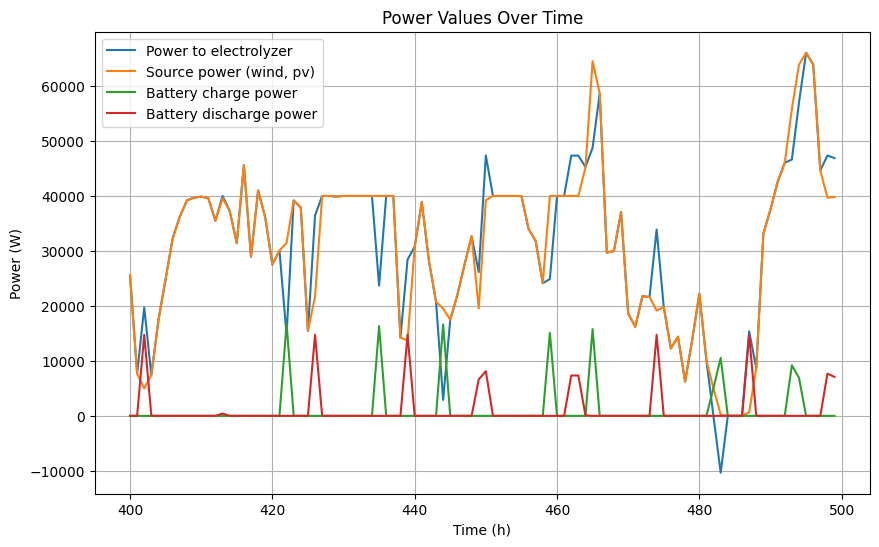

In [7]:
import matplotlib.pyplot as plt 

# Change these below values to adjust the time frame you are looking at for the graph
start, end = 400, 500
time_steps = list(range(start, end))

# Plot the power values against the time steps
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(time_steps, [i for i in power_to_electrolyzer[start:end]], label='Power to electrolyzer') # divide by 10 so can view all the values on one set of axes
plt.plot(time_steps, [i for i in source_after_rectifier[start:end]],label='Source power (wind, pv)')
plt.plot(time_steps, battery_charging[start:end], label='Battery charge power')
plt.plot(time_steps, battery_discharging[start:end], label='Battery discharge power')
plt.title('Power Values Over Time')
plt.xlabel('Time (h)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.show()